In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
from itertools import chain

In [2]:
import warnings
warnings.filterwarnings('ignore')

Читаем табличку с адресами и координатами:

In [3]:
coords_db = pd.read_csv("moscow_coords.csv", usecols=["ADDRESS", "geoData"], dtype=str)

In [4]:
print(coords_db.shape)
coords_db.head()

(406934, 2)


,ADDRESS,geoData
0,"город Москва, Варшавское шоссе, дом 150, строе...","{ ""coordinates"" : [ [ [ 37.6013796035561 , 55...."
1,"город Москва, Косинская улица, дом 26А","{ ""coordinates"" : [ [ [ 37.8279504545784 , 55...."
2,"город Москва, Гороховский переулок, дом 21","{ ""coordinates"" : [ [ [ 37.6682995208392 , 55...."
3,"город Москва, Тагильская улица, дом 4, строени...","{ ""coordinates"" : [ [ [ 37.7527975561661 , 55...."
4,"город Москва, Ленинградский проспект, дом 73А,...","{ ""coordinates"" : [ [ [ 37.5136462392231 , 55...."


Парсим координаты:

In [5]:
def parse_coordinate(str_dct):
    if not isinstance(str_dct, str) or str_dct == "Значение превышает максимальный размер ячейки Excel.":
        return np.zeros(2)
    
    d = json.loads(str(str_dct))
    c = d["coordinates"]
    c = list(chain.from_iterable(c))
    if isinstance(c, list) and len(c) > 1:
        e = np.concatenate([np.array(r).reshape((-1, 2)) for r in c])
    else:
        e = np.array(c)
    return np.array(e).mean(axis=0)


coords_db["coor_x"] = coords_db["geoData"].apply(lambda x: parse_coordinate(x)[0])
coords_db["coor_y"] = coords_db["geoData"].apply(lambda x: parse_coordinate(x)[1])
coords_db = coords_db.drop(columns=["geoData"])

In [6]:
coords_db = coords_db.rename(columns={"ADDRESS": "address"})
print(coords_db.shape)
coords_db.head()

(406934, 3)


,address,coor_x,coor_y
0,"город Москва, Варшавское шоссе, дом 150, строе...",37.601252,55.599249
1,"город Москва, Косинская улица, дом 26А",37.828115,55.717493
2,"город Москва, Гороховский переулок, дом 21",37.668093,55.766224
3,"город Москва, Тагильская улица, дом 4, строени...",37.752887,55.818257
4,"город Москва, Ленинградский проспект, дом 73А,...",37.513546,55.803510


Уберём все строчки, в которых слово город встречается дважды или есть слово послеление, чтобы обрабатывать меньше строк - такие адреса точно не внутри садового.

In [7]:
def adr_is_bad(s):
    x = s.lower()
    cities_count = len(re.findall("город ", x))
    settl_count = len(re.findall("поселение ", x))
    settl_2_count = len(re.findall("поселок ", x))
    return cities_count > 1 or settl_count + settl_2_count != 0

In [8]:
coords_db = coords_db[~coords_db["address"].apply(adr_is_bad)]

In [9]:
print(coords_db.shape)
coords_db.sample(5)

(155526, 3)


,address,coor_x,coor_y
19007,"город Москва, Нагатинская набережная, дом 6, к...",37.635927,55.682656
187155,"город Москва, Садовая-Триумфальная улица, влад...",37.604410,55.771575
22333,"город Москва, Старая Басманная улица, дом 11А",37.658720,55.766260
23932,"город Москва, 2-й Вязовский проезд, дом 16, ст...",37.762728,55.715880
368246,"город Москва, улица Косыгина, дом 59, строение 2",37.530023,55.716942


## Переходим к полигонам:

In [10]:
filenames = ["poly_narrow.txt", "poly_medium.txt", "poly_wide.txt", "poly_superwide.txt"]

In [11]:
names = ["narrow", "medium", "wide", "superwide"]
colors = ["darkmagenta", "blueviolet", "plum", "thistle"]

In [12]:
polygons = []
for filename in filenames:
    poly_points = []
    with open(filename, "r") as f:
        for line in f.readlines():
            poly_points.append(line.strip().split(",")[:2])
    poly_points = np.array(poly_points)
    
    polygons.append(np.array(poly_points, dtype=float))

In [13]:
from sklearn.preprocessing import minmax_scale

In [14]:
def split_poly_in_out(poly, k):
    s = poly.shape[0] // 2 + k
    return poly[:s], poly[s:]

In [15]:
split_polygons = [split_poly_in_out(poly, k) for poly, k in zip(polygons, [6, 0, -3, 4])]

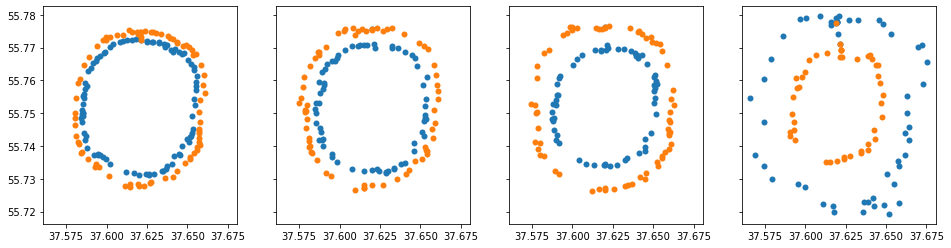

In [16]:
n_polygons = len(split_polygons)
figure, axes = plt.subplots(nrows=1, ncols=n_polygons, figsize=(16, 4), sharex=True, sharey=True)

for poly, ax in zip(split_polygons, axes):
    ax.scatter(poly[0][:, 0], poly[0][:, 1], linewidths=0.005)
    ax.scatter(poly[1][:, 0], poly[1][:, 1], linewidths=0.005)

plt.show()

In [17]:
house_coords = coords_db[["coor_x", "coor_y"]][coords_db[["coor_x", "coor_y"]]!=0].dropna().values

Уберём дома, которые точно вне полигонов:

In [18]:
def get_subhouses(houses, poly):
    x_min = np.min(poly[:, 0])
    x_max = np.max(poly[:, 0])
    y_min = np.min(poly[:, 1])
    y_max = np.max(poly[:, 1])
    
    a = houses[:, 0] > x_min
    b = np.logical_and(a, houses[:, 0] < x_max)
    c = np.logical_and(b, houses[:, 1] > y_min)
    d = np.logical_and(c, houses[:, 1] < y_max)

    return d

houses_mask = get_subhouses(coords_db[["coor_x", "coor_y"]].values, np.concatenate(polygons))

In [19]:
houses_mask.shape[0], houses_mask.sum()

(155526, 17907)

Осталось 12к домов

In [20]:
coords_sub_db = coords_db[houses_mask]
house_coords = coords_sub_db[["coor_x", "coor_y"]].values

In [21]:
import math
from PIL import Image

In [22]:
img = plt.imread('im0.jpeg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

На глаз разделим внешние и внутренние точки полигона:

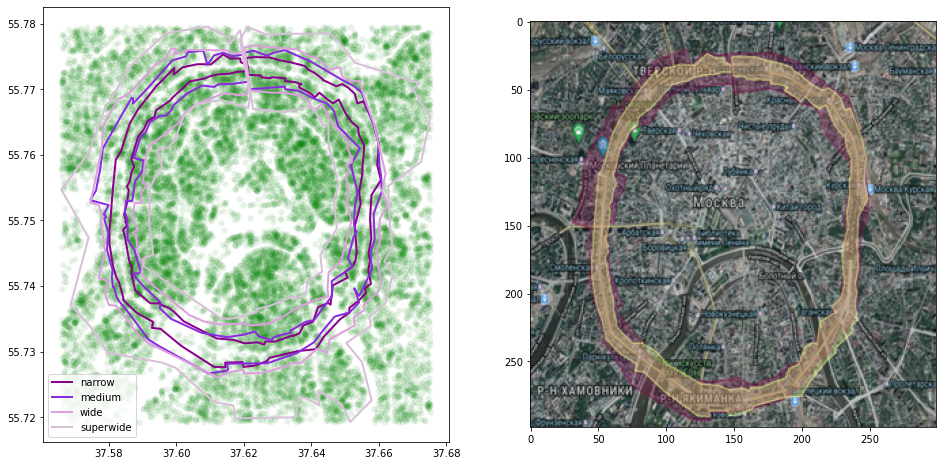

In [23]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

axes[0].scatter(house_coords[:, 0], house_coords[:, 1], linewidths=0.001, alpha=0.1, c="g")

for poly, name, c in zip(split_polygons, names, colors):
    axes[0].plot(poly[0][:, 0], poly[0][:, 1], linewidth=2, label=name, color=c)
    axes[0].plot(poly[1][:, 0], poly[1][:, 1], linewidth=2, color=c)

axes[0].legend(loc="lower left")
axes[1].imshow(img)

plt.show()

Научимся различать точки внутри полигона от всех остальных:

In [24]:
def area(x1, y1, x2, y2, x3, y3): 
    return abs((x1 * (y2 - y3) + x2 * (y3 - y1)  
                + x3 * (y1 - y2)) / 2.0) 

def isInside(x1, y1, x2, y2, x3, y3, x, y): 
    ABC = area (x1, y1, x2, y2, x3, y3) 
    PBC = area (x, y, x2, y2, x3, y3)  
    PAC = area (x1, y1, x, y, x3, y3)
    PAB = area (x1, y1, x2, y2, x, y) 

    return np.isclose(ABC, PBC + PAC + PAB)

def point_inside_poly(poly, point):
    x_min = np.min(poly[:, 0])
    x_max = np.max(poly[:, 0])
    y_min = np.min(poly[:, 1])
    y_max = np.max(poly[:, 1])
    if point[0] < x_min or point[0] > x_max or point[1] < y_min or point[1] > y_max:
        return False
    
    center = poly.mean(axis=0)
    res = False
    for a, b in zip(poly, np.concatenate([poly[1:], poly[:1]])):
        res = res or isInside(*center, *a, *b, *point)
    return res

In [25]:
inside_polygon = []
for poly, name in zip(split_polygons, names):
    inside_inner = np.array([point_inside_poly(poly[0], h) for h in house_coords])
    inside_outer = np.array([point_inside_poly(poly[1], h) for h in house_coords])
    between = np.logical_xor(inside_inner, inside_outer)
    print("Houses in {} polygon: {}".format(name, np.sum(between)))
    inside_polygon.append(between)

Houses in narrow polygon: 1795
Houses in medium polygon: 3195
Houses in wide polygon: 5108
Houses in superwide polygon: 9402


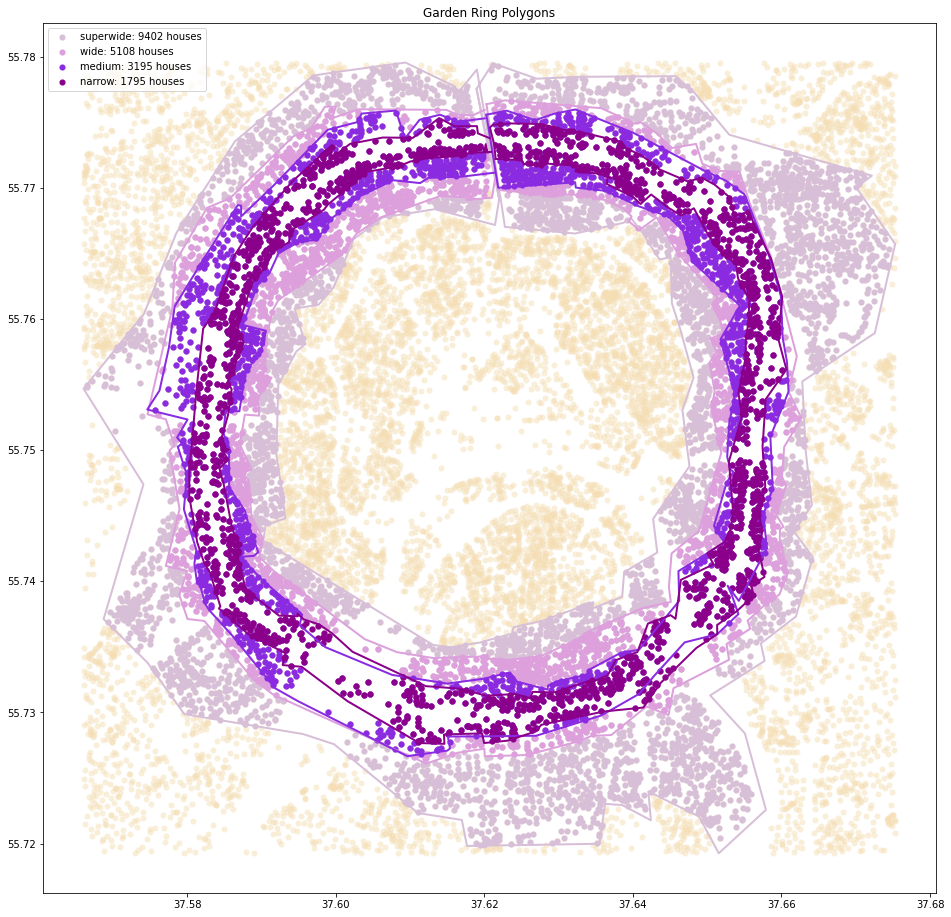

In [26]:
figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 16), sharex=True, sharey=True)


axes.set_title("Garden Ring Polygons")
axes.scatter(house_coords[:, 0], house_coords[:, 1], linewidths=0.001, alpha=0.5, c="wheat")

for name, label, color in zip(names[::-1], inside_polygon[::-1], colors[::-1]):
    axes.scatter(house_coords[label, 0], house_coords[label, 1], linewidths=0.1, alpha=1, c=color,  label="{}: {} houses".format(name, sum(label)))
    
for poly, name, color, label in zip(split_polygons[::-1], names[::-1], colors[::-1], inside_polygon[::-1]):
    axes.plot(poly[0][:, 0], poly[0][:, 1], linewidth=2, c=color)
    axes.plot(poly[1][:, 0], poly[1][:, 1], linewidth=2, color=color)


plt.legend(loc="upper left")

plt.show()

In [27]:
for name, labels in zip(names, inside_polygon):
    coords_sub_db[name] = labels

In [28]:
garden_ring_db = coords_sub_db[coords_sub_db["superwide"]]

In [29]:
print(garden_ring_db.shape)
garden_ring_db.sample(10)

(9402, 7)


,address,coor_x,coor_y,narrow,medium,wide,superwide
95945,"город Москва, Большой Сергиевский переулок, до...",37.630542,55.768472,False,False,False,True
115753,"город Москва, Николоямский переулок, дом 4-6, ...",37.661693,55.748206,False,False,False,True
28991,"город Москва, улица Большая Ордынка, дом 66, с...",37.623211,55.731884,False,True,True,True
42785,"город Москва, Боярский переулок, дом 4, строен...",37.647396,55.767807,False,True,True,True
167848,"город Москва, Пушкарёв переулок, владение 21/2...",37.631159,55.769209,False,False,False,True
199741,"город Москва, 7-й Ростовский переулок, владени...",37.573884,55.741677,False,False,False,True
38153,"город Москва, улица Зацепский Вал, дом 1/2, ст...",37.641988,55.731435,True,False,True,True
84004,"город Москва, улица Александра Солженицына, до...",37.660957,55.743886,False,False,False,True
29867,"город Москва, Токмаков переулок, дом 5, строен...",37.670219,55.768336,False,False,False,True
43676,"город Москва, Большая Грузинская улица, дом 32...",37.580071,55.767209,False,False,False,True


# Займёмся адресами:

Конвертируем всякие сокращения (используем те же сокращения, что и в таблице с портала mos.ru, импортируем её позже)

In [30]:
shortenings = [
    ("город", "г"),
    ("проспект", "пркт"),
    ("улица", "ул"),
    ("бульвар", "бр"),
    ("переулок", "пер"),
    ("проезд", "проезд"),
    ("шоссе", "ш"),
    ("площадь", "пл"),
    ("набережная", "наб"),
    ("дом", "д"),
    ("корпус", "к"),
    ("строение", "стр"),
    ("сооружение", "сооруж"),
    ("большой", "б"),
    ("большая", "б"),
    ("средний", "ср"),
    ("средняя", "ср"),
    ("малый", "м"),
    ("малая", "м")
]

In [31]:
def shorten_address(s, shrt=shortenings):
    x = s.lower()
    x = re.sub(r"[\.\,\-]", "", x)
    
    for a, b in shortenings:
        x = re.sub(a, b, x)
    x = re.sub(r"г москва", "", x)
    return x.strip()

def clip_bad_prefix(s, prefix="внутригская территория муниципальный округ"):
    if prefix in s:
        return " ".join(s.split()[len(prefix.split()) + 1:])

    return s

s = "внутригская территория муниципальный округ замоскворечье 6й монетчиковский пер д 12"
print(clip_bad_prefix(s))

6й монетчиковский пер д 12


In [32]:
garden_ring_db["short_address"] = garden_ring_db["address"].apply(shorten_address).apply(clip_bad_prefix)

In [33]:
garden_ring_db.sample(10)

,address,coor_x,coor_y,narrow,medium,wide,superwide,short_address
179340,"город Москва, Новорязанская улица, дом 18, стр...",37.662449,55.771991,False,False,False,True,новорязанская ул д 18 стр 27
9382,"город Москва, улица Бурденко, дом 1",37.582341,55.738504,False,True,True,True,ул бурденко д 1
111056,"город Москва, Трубниковский переулок, дом 21, ...",37.586800,55.755519,False,True,True,True,трубниковский пер д 21 стр 1
62888,"город Москва, улица Щипок, дом 22, строение 1",37.634426,55.723727,False,False,False,True,ул щипок д 22 стр 1
55112,"город Москва, Большой Факельный переулок, дом ...",37.662853,55.742350,False,False,False,True,б факельный пер д 6/12
6948,"город Москва, улица Щепкина, дом 24, строение 1",37.629299,55.777795,False,False,False,True,ул щепкина д 24 стр 1
10007,"город Москва, Люсиновская улица, дом 4",37.622342,55.727375,False,False,True,True,люсиновская ул д 4
22200,"город Москва, 2-й Щемиловский переулок, дом 8-...",37.608699,55.777665,False,False,False,True,2й щемиловский пер д 810 к б
160799,"город Москва, переулок Сивцев Вражек, владение...",37.590223,55.747340,False,False,False,True,пер сивцев вражек владение 30 стр 1
48415,"город Москва, Дегтярный переулок, дом 10, стро...",37.604780,55.768737,False,False,True,True,дегтярный пер д 10 стр 2


Напишем небольшой парсер адресов:

In [34]:
s = "ул пречистенка д 40/2 стр 1"
def parse_address(s, prefixes=["д", "к", "стр", "сооруж"]):
    x = s.lower()
    x = re.sub(r"[\.\,\-]", "", x)
    x = re.sub(r"г москва", "", x)

    entities = {}
    for prefix in prefixes:
        pattern = re.compile(prefix + " " + "(\d*\w*/?\d*\w*)")
        finds = re.findall(pattern, x)
        if len(finds):
            entity = re.findall(pattern, x)[0]
            entities[prefix] = entity
            x = re.sub(prefix + " " + entity, "", x)
        x = re.sub(r"\W+", " ", x)

    return x.strip(), entities

def match_address(s, addresses):
    pattern = "(" + "|".join(addresses) + ")"
    return ",".join(re.findall(pattern, s))


def norm_address(x):
    return " ".join(sorted(x.split()))

print(parse_address(s))
print(norm_address(s))

('ул пречистенка', {'д': '40/2', 'стр': '1'})
1 40/2 д пречистенка стр ул


## Вычитываем табличку с описанием домов

In [35]:
house_descr_db = pd.read_csv("data/dump2.csv")

In [36]:
print(house_descr_db.shape)
house_descr_db.head()

(34433, 60)


,id,region_id,area_id,city_id,street_id,shortname_region,formalname_region,shortname_area,formalname_area,shortname_city,...,electrical_entries_count,heating_type,hot_water_type,cold_water_type,sewerage_type,sewerage_cesspools_volume,gas_type,ventilation_type,firefighting_type,drainage_type
0,8649748,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,NaN,г,Москва,NaN,NaN,NaN,...,1.0,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Центральное,Центральное,"0,00",Центральное,Вытяжная вентиляция,Отсутствует,Внутренние водостоки
1,9370109,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,NaN,г,Москва,NaN,NaN,NaN,...,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено
2,8963246,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,NaN,г,Москва,NaN,NaN,NaN,...,7.0,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Центральное,Центральное,NaN,Отсутствует,Приточно-вытяжная вентиляция,Пожарные гидранты,Внутренние водостоки
3,8932138,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,NaN,г,Москва,NaN,NaN,NaN,...,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено
4,8932139,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,NaN,г,Москва,NaN,NaN,NaN,...,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено


Оставляем только интересные нам столбцы. Можно посмотреть, сколько в них пропусков (в каждом столбце):

In [37]:
useful_columns = [
    "address",
    "house_number",
    "building",
    "block",
    "letter",
    "floor_count_max",
    "floor_count_min",
    "entrance_count",
    "quarters_count",
    "living_quarters_count",
    "unliving_quarters_count" 
]

In [38]:
house_descr_db = house_descr_db[useful_columns]

In [39]:
house_descr_db.isnull().sum(axis = 0)

address                        0
house_number                 470
building                   32706
block                      18326
letter                     34417
floor_count_max              304
floor_count_min             1589
entrance_count               339
quarters_count                 0
living_quarters_count       1552
unliving_quarters_count     1942
dtype: int64

Проделываем ту же процедуру сокращения адресов:

In [40]:
house_descr_db["short_address"] = house_descr_db["address"].apply(shorten_address).apply(clip_bad_prefix)

In [41]:
print(house_descr_db.shape)
house_descr_db.head()

(34433, 12)


,address,house_number,building,block,letter,floor_count_max,floor_count_min,entrance_count,quarters_count,living_quarters_count,unliving_quarters_count,short_address
0,"г. Москва, д. 9, к. 1",9,NaN,1,NaN,9.0,9.0,4.0,144,144.0,0.0,д 9 к 1
1,"г. Москва, д. 14, к. 1",14,NaN,1,NaN,NaN,NaN,NaN,0,NaN,NaN,д 14 к 1
2,"г. Москва, д. 42, к. 2",42,NaN,2,NaN,17.0,17.0,7.0,476,474.0,2.0,д 42 к 2
3,"г. Москва, д. 2301",2301,NaN,NaN,NaN,13.0,NaN,6.0,0,NaN,NaN,д 2301
4,"г. Москва, д. 2302",2302,NaN,NaN,NaN,11.0,9.0,3.0,0,NaN,NaN,д 2302


Создадим сущность `norm_address`, в котором слова из `short address` расположены в алфавитном порядке:

In [42]:
garden_ring_db["norm_address"] = garden_ring_db.short_address.apply(norm_address)
house_descr_db["norm_address"] = house_descr_db.short_address.apply(norm_address)

In [43]:
joined_db = pd.merge(
    garden_ring_db,
    house_descr_db,
    how="left",
    on="norm_address"
)

In [44]:
joined_db.sample(3)

,address_x,coor_x,coor_y,narrow,medium,wide,superwide,short_address_x,norm_address,address_y,...,building,block,letter,floor_count_max,floor_count_min,entrance_count,quarters_count,living_quarters_count,unliving_quarters_count,short_address_y
5179,"город Москва, улица Зацепа, дом 28, строение 1",37.631715,55.729742,True,True,True,True,ул зацепа д 28 стр 1,1 28 д зацепа стр ул,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7779,"город Москва, улица Плющиха, дом 59, строение 1",37.575415,55.736479,False,False,False,True,ул плющиха д 59 стр 1,1 59 д плющиха стр ул,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3267,"город Москва, Большая Грузинская улица, дом 36...",37.580922,55.767787,False,False,False,True,б грузинская ул д 36 стр 6,36 6 б грузинская д стр ул,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
shorts_garden = set(garden_ring_db["short_address"].values)
norms_garden = set(garden_ring_db["norm_address"].values)

shorts_descr = set(house_descr_db["short_address"].values) 
norms_descr = set(house_descr_db["norm_address"].values) 

Посмотрим, сколько адресов из таблицы с координатами нашлось:

In [46]:
shorts_intersect =  [x for x in shorts_garden if x in shorts_descr]
norms_intersect = [x for x in norms_garden if x in norms_descr]
print("In the widest ring found {} houses of {}".format(len(norms_intersect), len(shorts_garden)))

In the widest ring found 1675 houses of 9398


In [47]:
def address_lookup(series, s):
    return series[series.str.contains(s)]

In [48]:
lost_norms_addresses = [x for x in norms_garden if x not in norms_descr]

Посмотрим, какие там самые частые слова

In [49]:
from collections import Counter
from nltk.tokenize import WhitespaceTokenizer

In [50]:
c = Counter()
c_alpha = Counter()
tokenizer = WhitespaceTokenizer()

for adr in lost_norms_addresses:
    c.update([x for x in tokenizer.tokenize(adr) if len(x) > 4])

In [51]:
c.most_common(15)

[('владение', 393),
 ('басманная', 293),
 ('новая', 157),
 ('старая', 136),
 ('земляной', 133),
 ('грузинская', 104),
 ('дербеневская', 100),
 ('ордынка', 99),
 ('тупик', 92),
 ('сооруж', 90),
 ('николоямская', 87),
 ('каретный', 86),
 ('дубининская', 85),
 ('садовническая', 83),
 ('никитская', 83)]

Пойдём разбираться, что там с названиями улиц:

In [52]:
print(np.random.choice(address_lookup(pd.Series(lost_norms_addresses), "земляной"), 25))

['5 50а вал д земляной стр ул' '3 53 вал д земляной стр ул'
 '2б/н 34 вал д земляной стр ул' '5 57 вал д земляной стр ул'
 '2б/н 34 вал д земляной стр ул' '18 53 вал д земляной стр ул'
 '50а вал д земляной ул' '11 29 вал д земляной стр ул'
 '14/16 2 вал д земляной стр ул' '30 7 вал д земляной стр ул'
 '1 26 вал д земляной стр ул' '36 7 вал д земляной стр ул'
 '2 26 вал д земляной стр ул' '2 30 вал д земляной стр ул'
 '2 53 вал д земляной стр ул' '3 68/18 вал д земляной стр ул'
 '1 26 вал д земляной стр ул' '5 57 вал д земляной стр ул'
 '4 52 вал д земляной стр ул' '5 57 вал д земляной стр ул'
 '2 39/1 вал д земляной стр ул' '29 3 вал д земляной стр ул'
 '10 32 вал д земляной стр ул' '2 30 вал д земляной стр ул'
 '1 30 вал д земляной стр ул']


In [53]:
print(np.random.choice(address_lookup(house_descr_db["short_address"], "земляной"), 25))

['ул земляной вал д 1/4 стр 1' 'ул земляной вал д 32'
 'ул земляной вал д 23 стр 1' 'ул земляной вал д 2' 'ул земляной вал д 46'
 'ул земляной вал д 12/7 стр 1' 'ул земляной вал д 27 стр 2'
 'ул земляной вал д 32' 'ул земляной вал д 27 стр 2'
 'ул земляной вал д 3/1 стр 7' 'ул земляной вал д 6 стр 2'
 'ул земляной вал д 52/16 стр 3' 'ул земляной вал д 6 стр 2'
 'ул земляной вал д 32' 'ул земляной вал д 3/1 стр 7'
 'ул земляной вал д 48б' 'ул земляной вал д 1822 стр 1'
 'ул земляной вал д 25' 'ул земляной вал д 34 стр 3а'
 'ул земляной вал д 10' 'ул земляной вал д 24/30 стр 1а'
 'ул земляной вал д 52/16 стр 2' 'ул земляной вал д 39/1 стр 1'
 'ул земляной вал д 32' 'ул земляной вал д 3/1 стр 7']


In [54]:
print(np.random.choice(address_lookup(garden_ring_db["short_address"], "земляной"), 25))

['ул земляной вал д 1416 стр 1' 'ул земляной вал д 50а'
 'ул земляной вал д 29 стр 12' 'ул земляной вал д 29 стр 1'
 'ул земляной вал д 12/7 стр 5' 'ул земляной вал д 30 стр 7'
 'ул земляной вал з/у 57/6' 'ул земляной вал д 36 стр 4'
 'ул земляной вал д 34 стр 3б/н' 'ул земляной вал д 27 стр 5'
 'ул земляной вал д 52/16 стр 3' 'ул земляной вал д 37 стр 2'
 'ул земляной вал д 48а стр 9' 'ул земляной вал д 41 стр 1'
 'ул земляной вал д 34 стр 1б/н' 'ул земляной вал д 7 стр 1'
 'ул земляной вал д 41 стр 1' 'ул земляной вал д 1 стр 2а'
 'ул земляной вал д 12/7 стр 5' 'ул земляной вал д 25'
 'ул земляной вал д 29 стр 9' 'ул земляной вал д 64 стр 2'
 'ул земляной вал д 39/1 стр 2' 'ул земляной вал д 53 стр 2'
 'ул земляной вал д 25 стр 2']


Выглядит так, что правда многих домов нет в базе с мос.ру.

Соберём статистику по тем, что есть:

In [55]:
garden_house_desr = house_descr_db[house_descr_db["norm_address"].isin(norms_garden)]

In [56]:
stat_dbs = []

for name in names:
    db = joined_db[
        (joined_db[name] == True)
    ]

    db = db.groupby([name], as_index=False).agg(
        {
             "address_y": ["count"],
             "living_quarters_count":["mean",  "sum"],
             "quarters_count" : ["sum"],
             "entrance_count": ["mean",  "sum"],
             "floor_count_min": ["min", "mean", "max"],
             "floor_count_max": ["min", "mean", "max"],
        })
    stat_dbs.append(db)

In [57]:
stat_dbs[0]

narrow address_y living_quarters_count          quarters_count  \
             count                  mean      sum            sum   
0   True       305             55.798635  16349.0        18224.0   

  entrance_count        floor_count_min                floor_count_max  \
            mean    sum             min     mean   max             min   
0       2.916388  872.0             0.0  5.21843  17.0             2.0   

                   
       mean   max  
0  6.839465  26.0

In [58]:
stat_dbs[1]

medium address_y living_quarters_count          quarters_count  \
             count                  mean      sum            sum   
0   True       570             48.901639  26847.0        29294.0   

  entrance_count         floor_count_min                 floor_count_max  \
            mean     sum             min      mean   max             min   
0        2.54902  1430.0             0.0  5.412409  24.0             0.0   

                   
       mean   max  
0  6.714795  31.0

In [59]:
stat_dbs[2]

wide address_y living_quarters_count          quarters_count  \
            count                  mean      sum            sum   
0  True       921             47.158784  41877.0        46364.0   

  entrance_count         floor_count_min                 floor_count_max  \
            mean     sum             min      mean   max             min   
0       2.418502  2196.0             0.0  5.251969  25.0             0.0   

                   
       mean   max  
0  6.674009  31.0

In [60]:
stat_dbs[3]

superwide address_y living_quarters_count          quarters_count  \
                count                  mean      sum            sum   
0      True      1680             49.511125  80109.0        89525.0   

  entrance_count         floor_count_min                 floor_count_max  \
            mean     sum             min      mean   max             min   
0       2.486731  4123.0             0.0  5.343634  25.0             0.0   

                   
       mean   max  
0  6.811218  31.0